In [1]:
!pip install tensorflow

In [2]:
import os
import numpy as np
import shutil
import random
import warnings
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
from datetime import datetime
import cv2
from reportlab.pdfgen import canvas
import io

warnings.filterwarnings("ignore", category=UserWarning)


In [3]:
# Dossier d'origine
original_data_dir = r"D:\teeth_dataset"
train_source = os.path.join(original_data_dir, "Training")  # Vérifie bien le nom

# Nouveau dossier organisé
new_base_dir = r"D:\newdata_80_15_5"
new_train = os.path.join(new_base_dir, "train")
new_val = os.path.join(new_base_dir, "val")
new_test = os.path.join(new_base_dir, "test")

# Création des dossiers
for subdir in [new_train, new_val, new_test]:
    os.makedirs(os.path.join(subdir, "caries"), exist_ok=True)
    os.makedirs(os.path.join(subdir, "without_caries"), exist_ok=True)

# Split et copie avec 80/15/5
def split_and_copy(class_name, source_dir, dest_train, dest_val, dest_test):
    files = os.listdir(source_dir)
    random.shuffle(files)
    total = len(files)

    train_split = int(total * 0.8)
    val_split = int(total * 0.15)
    test_split = total - train_split - val_split  # le reste

    train_files = files[:train_split]
    val_files = files[train_split:train_split + val_split]
    test_files = files[train_split + val_split:]

    for f in train_files:
        shutil.copy(os.path.join(source_dir, f), os.path.join(dest_train, class_name, f))
    for f in val_files:
        shutil.copy(os.path.join(source_dir, f), os.path.join(dest_val, class_name, f))
    for f in test_files:
        shutil.copy(os.path.join(source_dir, f), os.path.join(dest_test, class_name, f))

#  Appliquer le split pour les deux classes
split_and_copy("caries",
               os.path.join(train_source, "caries"),
               new_train, new_val, new_test)

split_and_copy("without_caries",
               os.path.join(train_source, "without_caries"),
               new_train, new_val, new_test)

print("Répartition 80% train, 15% val, 5% test terminée.")

#  Fonction de comptage
def count_images(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])

def count_per_class(base_dir):
    caries = count_images(os.path.join(base_dir, "caries"))
    without = count_images(os.path.join(base_dir, "without_caries"))
    return caries, without

#  Statistiques
train_c, train_nc = count_per_class(new_train)
val_c, val_nc = count_per_class(new_val)
test_c, test_nc = count_per_class(new_test)

total = train_c + train_nc + val_c + val_nc + test_c + test_nc

print("\n Statistiques des données :")
print(f"Train     → Caries: {train_c}, Sans caries: {train_nc}, Total: {train_c + train_nc}")
print(f"Val       → Caries: {val_c}, Sans caries: {val_nc}, Total: {val_c + val_nc}")
print(f"Test      → Caries: {test_c}, Sans caries: {test_nc}, Total: {test_c + test_nc}")
print(f"Total global : {total} images")


Répartition 80% train, 15% val, 5% test terminée.

 Statistiques des données :
Train     → Caries: 241, Sans caries: 241, Total: 482
Val       → Caries: 212, Sans caries: 150, Total: 362
Test      → Caries: 122, Sans caries: 73, Total: 195
Total global : 1039 images


In [4]:
# Générateur d'augmentation
augmentor = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fonction d’augmentation ciblée
def augment_directory(directory, target_count):
    existing_files = os.listdir(directory)
    current_count = len(existing_files)

    if current_count >= target_count:
        print(f" Aucune augmentation nécessaire pour {directory} ({current_count}/{target_count})")
        return

    print(f" Augmentation dans {directory} ({current_count} → {target_count})...")
    i = 0
    while len(os.listdir(directory)) < target_count:
        img_path = os.path.join(directory, existing_files[i % current_count])
        img = load_img(img_path, target_size=(128, 128))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, 0)

        for batch in augmentor.flow(img_array, batch_size=1, save_to_dir=directory, save_format='jpeg'):
            break
        i += 1

    print(f" Augmentation terminée pour {directory} : {len(os.listdir(directory))} images")

#  Répertoires à équilibrer
base_dir = r"D:\newdata_80_15_5"
augment_directory(os.path.join(base_dir, "train", "without_caries"), 241)
augment_directory(os.path.join(base_dir, "val", "without_caries"), 145)
augment_directory(os.path.join(base_dir, "test", "without_caries"), 68)

#  Affichage final des quantités
def count_classes(base_dir):
    caries = len(os.listdir(os.path.join(base_dir, "caries")))
    no_caries = len(os.listdir(os.path.join(base_dir, "without_caries")))
    total = caries + no_caries
    return caries, no_caries, total

train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

train_c, train_nc, train_total = count_classes(train_dir)
val_c, val_nc, val_total = count_classes(val_dir)
test_c, test_nc, test_total = count_classes(test_dir)

print("\n Répartition FINALE après augmentation :")
print(f"Train      → Caries: {train_c}, Sans caries: {train_nc}, Total: {train_total}")
print(f"Validation → Caries: {val_c}, Sans caries: {val_nc}, Total: {val_total}")
print(f"Test       → Caries: {test_c}, Sans caries: {test_nc}, Total: {test_total}")


 Aucune augmentation nécessaire pour D:\newdata_80_15_5\train\without_caries (241/241)
 Aucune augmentation nécessaire pour D:\newdata_80_15_5\val\without_caries (150/145)
 Aucune augmentation nécessaire pour D:\newdata_80_15_5\test\without_caries (73/68)

 Répartition FINALE après augmentation :
Train      → Caries: 241, Sans caries: 241, Total: 482
Validation → Caries: 212, Sans caries: 150, Total: 362
Test       → Caries: 122, Sans caries: 73, Total: 195


In [5]:
#  Chemins vers les dossiers de données
new_train = r"D:\newdata_80_15_5\train"
new_val = r"D:\newdata_80_15_5\val"
new_test = r"D:\newdata_80_15_5\test"

#  Générateurs avec normalisation
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#  Générateurs flow_from_directory
train_generator = train_datagen.flow_from_directory(
    new_train,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    new_val,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    new_test,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)


Found 482 images belonging to 2 classes.
Found 362 images belonging to 2 classes.
Found 195 images belonging to 2 classes.


In [6]:
# Définition du modèle
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Entraînement
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping]
)


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.4948 - loss: 1.0729 - val_accuracy: 0.4586 - val_loss: 1.0193
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 917ms/step - accuracy: 0.6924 - loss: 0.9655 - val_accuracy: 0.8508 - val_loss: 0.8548
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8835 - loss: 0.7929 - val_accuracy: 0.9088 - val_loss: 0.6256
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9222 - loss: 0.5909 - val_accuracy: 0.8923 - val_loss: 0.5541
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 963ms/step - accuracy: 0.9208 - loss: 0.5227 - val_accuracy: 0.9337 - val_loss: 0.4404
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9418 - loss: 0.4458 - val_accuracy: 0.9199 - val_loss: 0.4142
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9220 - loss: 0.4104 - val_accuracy: 0.9448 - val_loss: 0.3653
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9403 - loss: 0.3664 - val_accuracy: 0.9420 - val

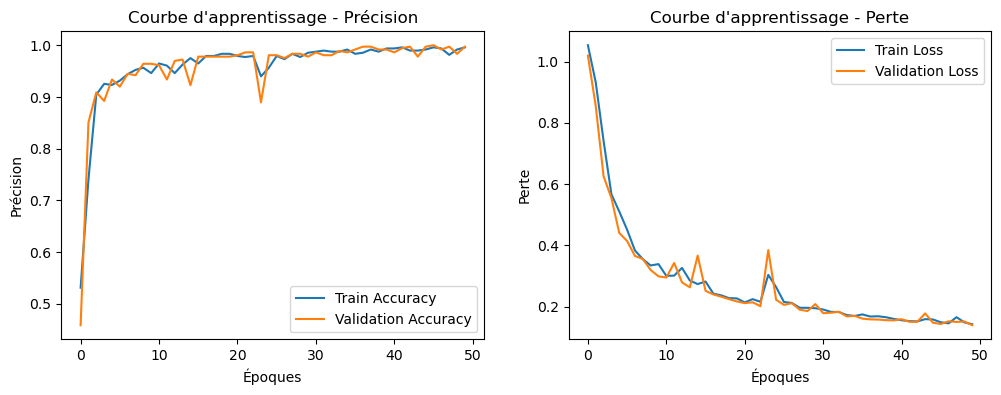

In [8]:
#  Affichage des courbes
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()
plt.title("Courbe d'apprentissage - Précision")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.title("Courbe d'apprentissage - Perte")

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


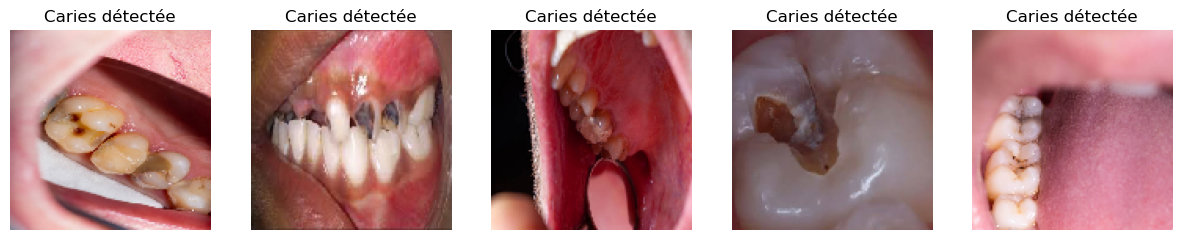

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


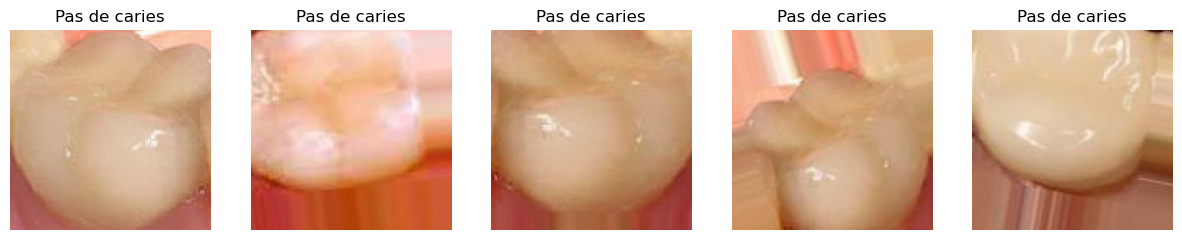

In [9]:
#  Prédiction sur images test
def predict_multiple_images(directory, model, num_images=8):
    all_images = os.listdir(directory)
    selected_images = random.sample(all_images, min(num_images, len(all_images)))

    plt.figure(figsize=(15, 6))

    for i, img_name in enumerate(selected_images):
        img_path = os.path.join(directory, img_name)
        img = image.load_img(img_path, target_size=(128, 128))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array)[0][0]
        result = "Pas de caries" if prediction > 0.5 else "Caries détectée"

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(result, fontsize=12)
        plt.axis("off")

    plt.show()
predict_multiple_images(os.path.join(new_test, 'caries'), model, num_images=5)
predict_multiple_images(os.path.join(new_test, 'without_caries'), model, num_images=5)


In [10]:
model.save("SAEmodel.h5")
print("Modèle sauvegardé sous le nom 'SAEmodel.h5'")


Modèle sauvegardé sous le nom 'SAEmodel.h5'


In [2]:
import tensorflow as tf
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
from datetime import datetime
import cv2
from reportlab.pdfgen import canvas
import io
import numpy as np

# Chargement du modèle
model = tf.keras.models.load_model("SAEmodel.h5")

def preprocess_image(image_pil):
    img = image_pil.resize((128, 128))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict(image_pil):
    image = preprocess_image(image_pil)
    prediction = model.predict(image)[0][0]
    return prediction

def open_image():
    file_path = filedialog.askopenfilename(filetypes=[("Images", "*.png;*.jpg;*.jpeg;*.bmp")])
    if not file_path:
        return

    img_cv = cv2.imread(file_path)
    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img_rgb)

    pred = predict(img_pil)
    global current_image, current_result, current_pred
    current_image = img_cv
    current_pred = pred
    current_result = "Caries détectées" if pred < 0.5 else "Pas de caries"

    display_result(img_cv, current_result, pred)

def display_result(image_cv, result_text, pred):
    img_resized = cv2.resize(image_cv, (250, 250))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img_rgb)
    img_tk = ImageTk.PhotoImage(img_pil)
    image_label.configure(image=img_tk)
    image_label.image = img_tk

    color = "red" if result_text == "Caries détectées" else "green"
    result_var.set(result_text + f"\nProbabilité carie : {100 - current_pred * 100:.2f}%\nProbabilité saine : {current_pred * 100:.2f}%")
    result_label.config(fg=color)

def save_report():
    if current_result and current_image is not None:
        now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        pdf_filename = f"rapport_dentaire_{now}.pdf"
        img_filename = f"image_analyse_{now}.jpg"

        # Sauvegarde de l'image analysée : JPEG
        cv2.imwrite(img_filename, current_image)

        # Génération du PDF
        c = canvas.Canvas(pdf_filename)
        c.setFont("Helvetica-Bold", 16)
        c.drawString(100, 800, "Rapport d'analyse de caries dentaires")

        c.setFont("Helvetica", 12)
        c.drawString(100, 770, f"Date : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        c.drawString(100, 750, f"Résultat : {current_result}")
        c.drawString(100, 730, f"Probabilité carie : {100 - current_pred * 100:.2f}%")
        c.drawString(100, 710, f"Probabilité saine : {current_pred * 100:.2f}%")

        #  Ajout de l'image dans le PDF
        try:
            from reportlab.lib.utils import ImageReader
            image_reader = ImageReader(img_filename)
            c.drawImage(image_reader, 100, 400, width=300, height=300)  # Redimensionnée
        except Exception as e:
            print("Erreur lors de l'ajout de l'image :", e)

        c.setFont("Helvetica-Oblique", 10)
        c.drawString(100, 100, "Ce rapport est informatif. Consultez un dentiste.")

        c.save()
        messagebox.showinfo("Succès", f"Rapport PDF sauvegardé sous : {pdf_filename}")


def reset_interface():
    image_label.configure(image="")
    image_label.image = None
    result_var.set("")
    global current_image, current_result, current_pred
    current_image = None
    current_result = None
    current_pred = 0.0

# Interface principale
root = tk.Tk()
root.title("Détection de Caries par IA")
root.geometry("800x550")
root.configure(bg="#ECF0F1")

current_image = None
current_result = None
current_pred = 0.0

tk.Label(root, text="\U0001F9B7 Détection de Caries Dentaires (IA)", font=("Helvetica", 20, "bold"), bg="#ECF0F1").pack(pady=15)

btn = tk.Button(root, text="\U0001F4C2 Charger une image", font=("Arial", 12), command=open_image, bg="#3498DB", fg="white")
btn.pack(pady=10)

image_label = tk.Label(root, bg="white", width=250, height=250, relief="solid")
image_label.pack(pady=10)

result_var = tk.StringVar()
result_label = tk.Label(root, textvariable=result_var, font=("Arial", 14, "bold"), bg="#ECF0F1")
result_label.pack(pady=10)

actions = tk.Frame(root, bg="#ECF0F1")
actions.pack(pady=15)

btn_save = tk.Button(actions, text="📄 Enregistrer le rapport", font=("Arial", 11), command=save_report, bg="#2ECC71", fg="white")
btn_save.grid(row=0, column=0, padx=10)

btn_reset = tk.Button(actions, text="🔄 Interface d'accueil", font=("Arial", 11), command=reset_interface, bg="#E67E22", fg="white")
btn_reset.grid(row=0, column=1, padx=10)

root.mainloop()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
